This notebook is only used to train and save a machine learning model. The goal of the project is not to build the best model, but to test the deployment of the model. Thus, there will not be much data exploration and no sophisticated model tweaking.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy.stats import uniform, truncnorm, randint

import pickle


## Import the data

In [2]:
train = pd.read_csv('data/train.csv')

## Cleaning the data
This mode of data cleaning is very rough and would normally be done more thoroughly. Since the quality of the model is not that important for this project, I stick with the "sledgehammer" methods.

In [3]:
def titanic_pipe(df):
    data = df.copy()
    
    # delete columns that contain text (except for sex)
    data.drop(['Cabin','Name','Ticket','PassengerId'],axis=1,inplace=True)
    
    # make dummies from 'sex' and drop the column
    data['Male'] = [1 if gender == 'male' else 0 for gender in data['Sex']]
    data.drop('Sex',axis=1,inplace=True)
    
    # make dummies from 'embarked'
    data = data.join(pd.get_dummies(data.Embarked,prefix='Embarked_',drop_first=True))
    data.drop('Embarked',axis=1,inplace=True)
    
    # replace missing values for age with mean 
    data.Age.fillna(data.Age.mean(),inplace=True)
    
    # drop the variable 'Fare' from the dataset (even though it could be a good indicator of survival)
    data.drop('Fare',axis=1,inplace=True)
    
    y = data.pop('Survived')
    x = data
    
    return x,y

In [4]:
# use the pipeline to clean data and create dummies
x, y = titanic_pipe(train)

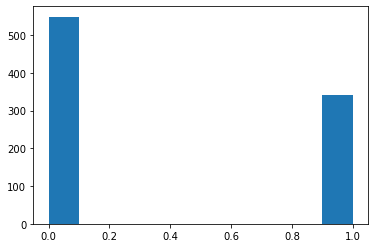

In [5]:
plt.hist(y);

## Split the data into train and test

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.12, random_state=42)

In [7]:
x_test.head()

,Pclass,Age,SibSp,Parch,Male,Embarked__Q,Embarked__S
709,3,29.699118,1,1,1,0,0
439,2,31.000000,0,0,1,0,1
840,3,20.000000,0,0,1,0,1
720,2,6.000000,0,1,0,0,1
39,3,14.000000,1,0,0,0,0


## Build the model

In [27]:
# setup search grid
model_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(4,200),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.01, 0.2)
}


In [29]:
# define the classifier
rf = RandomForestClassifier(random_state=42)
# set up the random search 
clf = RandomizedSearchCV(rf,model_params,n_iter=100,cv=10,random_state=42)

# train the model using random search
clf_fit = clf.fit(x_train, y_train)

# get best performing model params
model = clf_fit.best_estimator_

In [30]:
# calculate how many predictions would have been correct
y_pred = model.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8317757009345794


In [33]:
# calculate percentage of deaths in test set
1-(sum(y_test)/len(y_test))

# compared to 60% accuracy when always predicting death, our simple model is much better

0.6074766355140186

In [31]:
metrics.confusion_matrix(y_test,y_pred)

array([[58,  7],
       [11, 31]], dtype=int64)

## Save the model

In [35]:
with open('titanic_randomforest.pkl','wb') as pkl:
    pickle.dump(model,pkl)

In [33]:
# the following will be used in the app to load the model and predict a probability of survival
with open('app/titanic_randomforest.pkl','rb') as pkl:
    model = pickle.load(pkl)
    
#model.predict_proba(x_test)

In [45]:
x_test[9:10]

,Pclass,Age,SibSp,Parch,Male,Embarked__Q,Embarked__S
136,1,19.0,0,2,0,0,1


In [46]:
model.predict_proba(x_test[9:10])

array([[0.20551832, 0.79448168]])

In [47]:
y_test[9:10]

136    1
Name: Survived, dtype: int64